![跟踪器](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&file=BQML+Univariate+Forecasting+with+ARIMA%2B.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BQML%20Univariate%20Forecasting%20with%20ARIMA%2B.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>在<br>Colab中运行
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Forecasting%2FBQML%2520Univariate%2520Forecasting%2520with%2520ARIMA%252B.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>在<br>Colab Enterprise中运行
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BQML%20Univariate%20Forecasting%20with%20ARIMA%2B.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>在<br>GitHub上查看
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Forecasting/BQML%20Univariate%20Forecasting%20with%20ARIMA%2B.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>在<br>Vertex AI Workbench中打开
    </a>
  </td>
</table>

# BigQuery ML（BQML）-具有ARIMA+的单变量预测

在本笔记本中，我们将对在[预处理笔记本](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)中审查和准备的数据拟合一个预测模型-纽约市中央公园附近的citibike自行车租赁站的日租量。对于此尝试，我们通过使用BigQuery内置的机器学习（通常称为BQML）在数据仓库内保持预测活动。已提供的一个模型类型是ARIMA+（`model_type = 'ARIMA_PLUS'`）。这个模型通过使用自回归积分移动平均（ARIMA）模型来拟合单变量预测，同时还会自动处理许多所需的数据预处理和后处理步骤。通过简单地将站点名称作为`start_station_name`提供给输入参数`time_series_id_col`，每个站点将被单独预测。将使用各种提供的指标评估预测，并使用SQL计算定制指标。甚至可以使用BigQuery ML的`ML.DETECT_ANOMALIES`函数来识别异常。

**ARIMA+**

ARIMA是一种用于了解模式和预测未来时间点的时间序列数据的统计模型。该模型由三部分组成：
- AR，或自回归。表示变量与其自身以前值的回归。
    - `p`，指示考虑的滞后数或以前的时间点数的参数
- I，或集成。指示已用值与前一个值的差替换的值。
    - `d`，指示差分程度或数据已被减去过去值的次数
- MA，或移动平均。表示回归误差是过去各个时间点的值的组合。
    - `q`，指示移动平均的顺序的参数

参考：
- [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

---

**系列概述**

[此系列](./readme.md)探讨了使用Vertex AI、BigQuery ML和其他开源框架进行预测。预测是指随着时间的推移跟踪测量并探索趋势、季节性的影响（年、月、日等）、假期和特殊事件，希望利用这些见解预测未来的趋势。一些方法还会包含影响需求的可观测测量，以理解关系并使预测更加准确。

**数据源：纽约市Citibike租赁**

此系列使用纽约市的Citibike租赁数据。将选择靠近中央公园的自行车站，并随时间跟踪从这些站点起始的每日自行车行程数。这将说明由于随着时间推移引入新站点，一些站点只有最近的几个月甚至只有几周的数据，导致一些常见的预测问题。这些数据可以在BigQuery公共数据集中找到：
- `bigquery-public-data.new_york.citibike_trips`
- `bigquery-public-data.new_york.citibike_stations`

**BigQuery ML（BQML）概述**

[BigQuery ML](https://cloud.google.com/bigquery/docs/bqml-introduction)允许您使用`SQL`构建机器学习工作流。当数据源是[BigQuery](https://cloud.google.com/bigquery/docs/introduction)，用户已经熟悉`SQL`时，这将极大地提高生产率和灵活性。只需使用`SQL`，可以使用多种技术进行模型训练，甚至包括[超参数调整](https://cloud.google.com/bigquery/docs/hp-tuning-overview)。它包括用于监督学习、无监督学习、时间序列方法甚至推荐引擎的无服务器[训练、评估和推断](https://cloud.google.com/bigquery/docs/e2e-journey)技术。可以直接在BigQuery中提供[预测](https://cloud.google.com/bigquery/docs/inference-overview)，其中还包括可解释性措施。预测模型可以[导出到其本机框架](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-export-model)以实现可移植性，甚至可以直接[注册到Vertex AI模型注册表](https://cloud.google.com/bigquery/docs/create_vertex)以在Vertex AI端点上进行在线预测。可以从许多常见框架[导入模型到BigQuery ML](https://cloud.google.com/bigquery/docs/inference-overview#inference_using_imported_models)，或者从Vertex AI端点[连接到远程托管的模型](https://cloud.google.com/bigquery/docs/inference-overview#inference_using_remote_models)。甚至可以直接在Vertex AI上使用许多[预训练模型](https://cloud.google.com/bigquery/docs/inference-overview#pretrained-models)如Cloud Vision API、Cloud Natural Language API、Cloud Translate API和在Vertex AI上托管的生成AI LLM。

了解可用方法范围的绝佳起点是[模型用户旅程](https://cloud.google.com/bigquery/docs/e2e-journey)。该存储库还包含一系列基于笔记本的工作流，用于回顾这里的许多BigQuery ML方法：[../03 - BigQuery ML（BQML）](../03%20-%20BigQuery%20ML%20(BQML)/readme.md)。

---

**先决条件：**
- [BigQuery时间序列预测数据审查和准备](./BigQuery%20Time%20Series%20Forecasting%20Data%20Review%20and%20Preparation.ipynb)
    - 为本笔记本准备数据

**资源：**
- [BigQuery](https://cloud.google.com/bigquery/docs/introduction)
    - [BigQuery Python客户端](https://cloud.google.com/python/docs/reference/bigquery/latest)
    - [BigQuery ML](https://cloud.google.com/python/docs/reference/bigquery/latest)
    - [SQL参考](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
    - [BigQuery ML SQL参考](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series)
- [每个模型的BigQuery ML端到端用户旅程](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- 博客：[如何在BigQuery中进行时间序列预测](https://towardsdatascience.com/how-to-do-time-series-forecasting-in-bigquery-af9eb6be8159)
- [Vertex AI预测：概述](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [代码实验：使用Vertex AI和BigQuery ML进行时间序列预测](https://codelabs.developers.google.com/codelabs/time-series-forecasting-with-cloud-ai-platform#0)

**概念性流程和工作流程**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore2_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore2_console.png" width="45%">
</p>

## Colab 设置

要在 Colab 中运行此笔记本，请点击 [![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BQML%20Univariate%20Forecasting%20with%20ARIMA%2B.ipynb) 并运行此部分中的单元格。否则，请跳过此部分。

此单元格将对 GCP 进行身份验证（请按照弹出窗口中的提示操作）。

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [473]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

安装和API启用

客户端的软件包可能需要在这个环墅中安装。

### 安装（如果需要）

In [4]:
# tuples of (import name, install name)
packages = [
    ('plotly', 'plotly'),
    ('kaleido', 'kaleido')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### 重新启动内核（如果发生了安装）

重新启动内核后，代码提交可以从这个单元格之后的下一个单元格开始。

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## 设置

输入:

In [3]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [4]:
REGION = 'us-central1'
EXPERIMENT = 'bqml-arimaplus'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-data_prepped'

viz_limit = 12

包裹:

In [5]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

客户:

In [6]:
bq = bigquery.Client(project = PROJECT_ID)

时间序列回顾

**单变量预测**包括每个时间序列只有2列：
- `TARGET_COLUMN` = 需求测量。
    在我们的情况下，它是某个自行车站每天搭乘的次数 - 每天的搭乘次数总和。
- `TIME_COLUMN` = 需求的时间。
    以与预测练习的粒度相关的时间或日期单位表示。在我们的情况下，需求是按天计量的，因此时间列被准备为日期。

**其他列**用于指导预测算法处理数据：
- `SERIES_COLUMN`将与同一时间序列相关的行分组在一起。
    - 进行多个预测，每个时间序列一个，意味着包括第三列以捕获每个时间序列的行组：`SERIES_COLUMN`。
    - **注意：**BigQuery ARIMA+为每个这些组适配单独的预测。在我们的情况下，这是`start_station_name`，这是中央公园附近每个单独的Citibike站的名称。
- `SPLITS_COLUMN`在预测练习中将每个时间序列内的连续行分组。
    - 这些数据在预备笔记本中为`TRAIN`、`VALIDATE`和`TEST`准备了拆分。包含这些拆分的列可供所选的预测方法在训练期间使用，而不是让方法计算拆分。这在比较多种不同方法时很有帮助，因为它确保了拆分在每种方法中的处理方式是一致的。

**预测参数**：
- `FORECAST_GRANULARITY`是测量频率，例如MINUTE、HOUR、DAY、WEEK、MONTH、YEAR
    - 数据在准备数据笔记本中以DAY级别进行了总结
    - 这是测量之间的时间量 - 行
    - 对于不同的粒度，您可能需要为不同的时间部件将需求信号总结为`SUM`、`MIN`、`MAX`或`AVERAGE`。
    - 粒度的规范因方法而异：
        - BigQuery ML: PER_MINUTE、HOURLY、DAILY、WEEKLY、MONTHLY、QUARTERLY、YEARLY
        - Prophet（包括Vertex Pre-Built Pipelines）：minute、hour、day、week、month或year
        - Vertex AI AutoML：minute、hour、day、week、month、year
    - 一个非常有用的BigQuery函数用于提取时间和日期的组件是`EXTRACT`函数：
        - [日期提取函数](https://cloud.google.com/bigquery/docs/reference/standard-sql/date_functions#extract)
        - [时间提取函数](https://cloud.google.com/bigquery/docs/reference/standard-sql/time_functions#extract)
        - [日期时间提取函数](https://cloud.google.com/bigquery/docs/reference/standard-sql/datetime_functions#extract)。
- `FORECAST_TEST_LENGTH`是分配给测试区域的行数
    - 这是以`FORECAST_GRANULARITY`为单位的。
    - 数据准备包括设置此项以指定每个`SERIES_COLUMN`中的每个时间序列的`SPLITS_COLUMN = 'TEST'`值。
- `FORCAST_VALIDATE_LENGTH`是分配给验证区域的行数
    - 这是以`FORECAST_GRANULARITY`为单位的。
    - 数据准备包括设置此项以指定每个`SERIES_COLUMN`中的每个时间序列的`SPLITS_COLUMN = 'VALIDATE'`值。
- `FORECAST_HORIZON_LENGTH`是预测未来的行数超出测试区域
    - 这是以`FORECAST_GRANULARITY`为单位的。
    - 这需要设置为预测方法的输入。

In [7]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'

# CUSTOMIZE
FORECAST_GRANULARITY = 'DAILY' # the data preparation included preparing the data at this level
FORECAST_HORIZON_LENGTH = 14
FORECAST_TEST_LENGTH = 14 # the data preparation included setting this value for splits = TEST
FORECAST_VALIDATE_LENGTH = 14 # the data preparation included setting this value for splits = VALIDATE

检索拆分的关键日期:

In [8]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY {SPLIT_COLUMN}
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE {SPLIT_COLUMN} = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

检索原始数据:

In [9]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {SPLIT_COLUMN}, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### 绘制时间序列

使用 [Plotly](https://plotly.com/python/) 创建一个交互式图表，以查看单个时间序列（自行车站点）并通过滚动时间范围。

In [10]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] # + COVARIATE_COLUMNS # no covariate for univarate forecasting

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

In [11]:
print('A Snapshot of the interactive plot:')
fig.show('png')

A Snapshot of the interactive plot:


创建预测模型
参考[`model_type = 'ARIMA_PLUS'`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series)

使用BigQuery ML Arima+ (`model_type = 'ARIMA_PLUS'`), 一个[BigQuery ML](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)的特性。这个特性可以使用ARIMA进行单变量时间序列建模，同时自动化许多此类推断任务：预处理、假日调整、尖峰、下降、异常值、季节性和趋势分解、阶跃变化调整、趋势建模、预测。以下是BigQuery ML文档中此流程的表示:

<p><center>
    <img alt="ARIMA_PLUS Flowchart" src="https://cloud.google.com/static/bigquery/images/BQ_ARIMA_diagram.png" width="75%">
</center><p>

多个时间序列在同一时间被预测，每个个体站点靠近中央公园，使用`time_series_id_col = `输入。

**注意：** ARIMA预测是单变量的，不使用验证数据，因此我们在这里将其与训练数据一起包括进去:

In [12]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`
    OPTIONS
      (model_type = 'ARIMA_PLUS',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       time_series_id_col = '{SERIES_COLUMN}',
       data_frequency = '{FORECAST_GRANULARITY}',
       auto_arima_max_order = 5,
       holiday_region = ['GLOBAL', 'US'],
       horizon = {FORECAST_HORIZON_LENGTH} + {FORECAST_TEST_LENGTH}
      ) AS
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE {SPLIT_COLUMN} in ('TRAIN','VALIDATE')
"""
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

26.575

In [13]:
print(f'Review The Model in The BigQuery Console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}_arimaplus&pli=1')

Review The Model in The BigQuery Console:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-data_prepped_arimaplus&pli=1


### 查看ARIMA系数
参考[`ML.ARIMA_COEFFICIENTS`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients)

In [14]:
query = f"""
    SELECT *
    FROM ML.ARIMA_COEFFICIENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`)
    ORDER BY {SERIES_COLUMN}
"""
coefficients = bq.query(query).to_dataframe()
coefficients.head(viz_limit)

start_station_name  \
0   Central Park North & Adam Clayton Powell Blvd   
1                          Central Park S & 6 Ave   
2                        Central Park W & W 96 St   
3                    Central Park West & W 100 St   
4                    Central Park West & W 102 St   
5                     Central Park West & W 68 St   
6                     Central Park West & W 72 St   
7                     Central Park West & W 76 St   
8                     Central Park West & W 85 St   
9               Grand Army Plaza & Central Park S   
10                   W 106 St & Central Park West   
11                    W 82 St & Central Park West   

                                      ar_coefficients  \
0                                                  []   
1   [0.40211845745016567, 0.009007045791633118, 0....   
2                                 [0.606197201087799]   
3                                [0.3518355980348823]   
4                                                  []   
5          [-0.4909159274352166, -0.6576414019221655]   
6           [0.19266988112520386, 0.1760116500117399]   
7                                [0.9048210551797454]   
8                                                  []   
9                                                  []   
10         [-0.8405445660286137, -0.5496718463096316]   
11                                                 []   

                                      ma_coefficients  intercept_or_drift  
0   [0.4367042956076374, -0.016512649634778276, -0...          169.292694  
1                               [-0.9673224121657438]            0.000000  
2                                                  []          104.092507  
3                                                  []           40.380671  
4   [0.024759641179645575, 0.20624615867712248, -0...           52.152300  
5   [-0.18611318662235532, 0.618347299875246, -0.7...            0.355314  
6                                [-0.866416243697985]            0.000000  
7   [-1.3859469751885198, 0.19447063140615053, 0.3...            0.329763  
8   [-0.3901300567684862, -0.7393964989036537, 0.7...            0.000000  
9   [-0.6209394434074978, -0.44167478630555357, 0....            0.049942  
10                                                 []            0.000000  
11  [-0.8173891009542463, -0.14621707877386442, 0....            0.000000

### 回顾输入特征
请参考[`ML.FEATURE_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-feature)。

In [15]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()

input  min    max        mean  median     stddev  \
0           num_trips  1.0  555.0  119.446128   100.0  87.921883   
1           starttime  NaN    NaN         NaN     NaN        NaN   
2  start_station_name  NaN    NaN         NaN     NaN        NaN   

   category_count  null_count  dimension  
0            <NA>           0       <NA>  
1            1170           0       <NA>  
2              12           0       <NA>

### 查看培训信息
请参考[`ML.TRAINING_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train)。

In [16]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`)
"""
trainingInfo = bq.query(query).to_dataframe()
trainingInfo.head()

training_run  iteration  duration_ms
0             0          0         9686

预测评估

### 预测指标
对于 `model_type = 'ARIMA_PLUS'`，请参考 [`ML.EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)。

返回的指标取决于是否提供了输入（测试）数据以及 `perform_aggregation` 是否为 `True` 或 `False`。如果为 `False`，则提供每个时间戳的指标；如果为 `True`，则提供每个 `time_series_id_col` 的指标。

In [17]:
query = f"""
    SELECT *
    FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`,
    (
        SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE {SPLIT_COLUMN} = 'TEST'
        ORDER BY {SERIES_COLUMN}
    ),
    STRUCT(TRUE AS perform_aggregation))
"""
metrics = bq.query(query).to_dataframe()
metrics.head(viz_limit)

start_station_name  mean_absolute_error  \
0   Central Park North & Adam Clayton Powell Blvd            40.519533   
1                          Central Park S & 6 Ave            86.673929   
2                        Central Park W & W 96 St            21.729312   
3                    Central Park West & W 100 St            18.610058   
4                    Central Park West & W 102 St            14.568555   
5                     Central Park West & W 68 St            42.457613   
6                     Central Park West & W 72 St            37.385787   
7                     Central Park West & W 76 St            27.026844   
8                     Central Park West & W 85 St            53.979223   
9               Grand Army Plaza & Central Park S            51.585408   
10                   W 106 St & Central Park West            14.356956   
11                    W 82 St & Central Park West            32.113632   

    mean_squared_error  root_mean_squared_error  \
0          3339.344260                57.787060   
1         12227.126512               110.576338   
2          1016.374801                31.880634   
3           482.209233                21.959263   
4           332.562812                18.236305   
5          2430.773248                49.302873   
6          3406.825214                58.368015   
7          1181.265559                34.369544   
8          4709.508389                68.625858   
9          5100.789447                71.419811   
10          323.219810                17.978315   
11         1781.537621                42.208265   

    mean_absolute_percentage_error  symmetric_mean_absolute_percentage_error  
0                        65.497641                                 32.165275  
1                        44.217057                                 32.999294  
2                        54.169130                                 27.164336  
3                        87.537112                                 50.606040  
4                        53.150445                                 32.238560  
5                        43.207754                                 30.658993  
6                        57.404966                                 25.423404  
7                        37.325512                                 26.111466  
8                        95.295942                                 49.453879  
9                        44.227514                                 27.547616  
10                       27.530929                                 22.766975  
11                       34.276921                                 37.675419

### 评估时间序列模型
[`ML.ARIMA_EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-arima-evaluate) 的参考文档

每个时间序列，在创建时使用`time_series_id_col`指定，模型指标表：
ARIMA术语：
- p = 自回归项的数量
- d = 使时间序列平稳所需的非季节性差分数量
- q = 滞后的预测误差数（移动平均部分）

In [18]:
query = f"""
    SELECT *
    FROM ML.ARIMA_EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`)
    ORDER BY {SERIES_COLUMN}
"""
arima_metrics = bq.query(query).to_dataframe()
arima_metrics.head(viz_limit)

start_station_name  non_seasonal_p  \
0   Central Park North & Adam Clayton Powell Blvd               0   
1                          Central Park S & 6 Ave               3   
2                        Central Park W & W 96 St               1   
3                    Central Park West & W 100 St               1   
4                    Central Park West & W 102 St               0   
5                     Central Park West & W 68 St               2   
6                     Central Park West & W 72 St               2   
7                     Central Park West & W 76 St               1   
8                     Central Park West & W 85 St               0   
9               Grand Army Plaza & Central Park S               0   
10                   W 106 St & Central Park West               2   
11                    W 82 St & Central Park West               0   

    non_seasonal_d  non_seasonal_q  has_drift  log_likelihood           AIC  \
0                0               4      False      -76.109993    164.219985   
1                1               1      False    -5783.577720  11577.155439   
2                0               0      False     -210.602099    427.204198   
3                0               0      False     -175.395825    356.791651   
4                0               4      False     -165.517414    343.034827   
5                1               3       True    -1643.710815   3301.421629   
6                1               1      False    -1793.398363   3594.796727   
7                1               4       True    -1502.764921   3019.529841   
8                1               5      False    -1710.216785   3432.433571   
9                1               5       True    -5407.743173  10829.486345   
10               1               0      False     -157.275264    320.550529   
11               1               5      False    -1428.194806   2868.389612   

       variance  seasonal_periods  has_holiday_effect  has_spikes_and_dips  \
0    536.704789          [WEEKLY]               False                False   
1   1120.921591  [WEEKLY, YEARLY]                True                 True   
2    832.585329          [WEEKLY]               False                False   
3    375.632216  [NO_SEASONALITY]               False                 True   
4    189.056029  [NO_SEASONALITY]               False                False   
5    320.575801          [WEEKLY]                True                 True   
6    716.368271          [WEEKLY]                True                 True   
7    183.264631          [WEEKLY]                True                 True   
8   1121.729390          [WEEKLY]               False                 True   
9    589.325492  [WEEKLY, YEARLY]                True                 True   
10   354.239747          [WEEKLY]               False                False   
11   186.375832          [WEEKLY]               False                 True   

    has_step_changes error_message  
0              False                
1               True                
2              False                
3              False                
4              False                
5               True                
6               True                
7               True                
8              False                
9               True                
10             False                
11             False

### 模型中的节假日效应
参考 [`ML.HOLIDAY_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-holiday-info)

被建模并检测到节假日效应的节假日列表：
- `region`，这些在 `CREATE MODEL` 语句中使用 `holiday_region` 参数指定
- `holiday_name` 是具有检测效果的节假日名称
- `primary_date` 是节假日的日历日期
- `preholiday_days` 和 `postholiday_days` 是在建模过程中考虑的节假日周围的整数窗口

In [19]:
query = f"""
    SELECT *
    FROM ML.HOLIDAY_INFO(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`)
"""
holiday_info = bq.query(query).to_dataframe()
holiday_info

region            holiday_name primary_date  preholiday_days  \
0     GLOBAL  AllSaintsDay-Halloween   2000-10-31                1   
1     GLOBAL  AllSaintsDay-Halloween   2001-10-31                1   
2     GLOBAL  AllSaintsDay-Halloween   2002-10-31                1   
3     GLOBAL  AllSaintsDay-Halloween   2003-10-31                1   
4     GLOBAL  AllSaintsDay-Halloween   2004-10-31                1   
...      ...                     ...          ...              ...   
1619      US              VeteranDay   2026-11-11                1   
1620      US              VeteranDay   2027-11-11                1   
1621      US              VeteranDay   2028-11-11                1   
1622      US              VeteranDay   2029-11-11                1   
1623      US              VeteranDay   2030-11-11                1   

      postholiday_days  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
...                ...  
1619                 1  
1620                 1  
1621                 1  
1622                 1  
1623                 1  

[1624 rows x 5 columns]

---
## 时间序列预测
参考[`ML.FORECAST`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-forecast)

计算每个时间戳的预测值，并在请求的置信水平下提供标准误差和预测区间。

默认的`horizon`为3，因此可能需要将此参数设置为训练中使用的大小。

In [20]:
query = f"""
    SELECT *
    FROM ML.FORECAST(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`, STRUCT(1 AS horizon, 0.95 AS confidence_level))
    ORDER BY {SERIES_COLUMN}
"""
forecast = bq.query(query).to_dataframe()
forecast.head(viz_limit)

start_station_name        forecast_timestamp  \
0   Central Park North & Adam Clayton Powell Blvd 2016-09-17 00:00:00+00:00   
1                          Central Park S & 6 Ave 2016-09-17 00:00:00+00:00   
2                        Central Park W & W 96 St 2016-09-17 00:00:00+00:00   
3                    Central Park West & W 100 St 2016-09-17 00:00:00+00:00   
4                    Central Park West & W 102 St 2016-09-17 00:00:00+00:00   
5                     Central Park West & W 68 St 2016-09-17 00:00:00+00:00   
6                     Central Park West & W 72 St 2016-09-17 00:00:00+00:00   
7                     Central Park West & W 76 St 2016-09-17 00:00:00+00:00   
8                     Central Park West & W 85 St 2016-09-17 00:00:00+00:00   
9               Grand Army Plaza & Central Park S 2016-09-17 00:00:00+00:00   
10                   W 106 St & Central Park West 2016-09-17 00:00:00+00:00   
11                    W 82 St & Central Park West 2016-09-17 00:00:00+00:00   

    forecast_value  standard_error  confidence_level  \
0       222.073810       25.307050              0.95   
1       434.142037       33.480167              0.95   
2       122.160526       28.854555              0.95   
3        44.116929       19.381234              0.95   
4        45.519928       14.227731              0.95   
5       179.989099       17.946231              0.95   
6       271.012348       26.765057              0.95   
7       153.421424       13.553062              0.95   
8       125.442298       33.683213              0.95   
9       257.453551       24.276027              0.95   
10       78.472703       18.821258              0.95   
11       88.738432       13.674756              0.95   

    prediction_interval_lower_bound  prediction_interval_upper_bound  \
0                        172.561627                       271.585993   
1                        368.639493                       499.644581   
2                         65.707799                       178.613253   
3                          6.198358                        82.035500   
4                         17.683968                        73.355888   
5                        144.878050                       215.100148   
6                        218.647636                       323.377060   
7                        126.905427                       179.937421   
8                         59.542503                       191.342093   
9                        209.958521                       304.948581   
10                        41.649701                       115.295705   
11                        61.984345                       115.492520   

    confidence_interval_lower_bound  confidence_interval_upper_bound  
0                        172.561627                       271.585993  
1                        368.639493                       499.644581  
2                         65.707799                       178.613253  
3                          6.198358                        82.035500  
4                         17.683968                        73.355888  
5                        144.878050                       215.100148  
6                        218.647636                       323.377060  
7                        126.905427                       179.937421  
8                         59.542503                       191.342093  
9                        209.958521                       304.948581  
10                        41.649701                       115.295705  
11                        61.984345                       115.492520

## 时间序列预测与解释
参考[`ML.EXPLAIN_FORECAST`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-explain-forecast)

BigQuery ML具有增强的预测功能，还包括解释信息。 `model_type = 'ARIMA_PLUS'`的默认参数之一是`decompose_time_series = True`，这使得该功能可用。

除了预测和相应的预测区间，还包括趋势、季节性、假日效应、高峰和低谷以及阶跃变化的实际值和信息。

In [21]:
query = f"""
    SELECT *, 
        EXTRACT(DATE FROM time_series_timestamp) AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`,
        STRUCT({FORECAST_HORIZON_LENGTH + FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level))
    ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()

In [22]:
explain.tail()

start_station_name     time_series_timestamp time_series_type  \
4694  W 82 St & Central Park West 2016-10-10 00:00:00+00:00         forecast   
4695  W 82 St & Central Park West 2016-10-11 00:00:00+00:00         forecast   
4696  W 82 St & Central Park West 2016-10-12 00:00:00+00:00         forecast   
4697  W 82 St & Central Park West 2016-10-13 00:00:00+00:00         forecast   
4698  W 82 St & Central Park West 2016-10-14 00:00:00+00:00         forecast   

      time_series_data  time_series_adjusted_data  standard_error  \
4694         73.385875                  73.385875       21.976428   
4695         67.075769                  67.075769       22.103553   
4696         58.180525                  58.180525       22.229951   
4697         43.376116                  43.376116       22.355634   
4698         66.707370                  66.707370       22.480614   

      confidence_level  prediction_interval_lower_bound  \
4694              0.95                        30.389914   
4695              0.95                        23.831094   
4696              0.95                        14.688558   
4697              0.95                        -0.361745   
4698              0.95                        22.724990   

      prediction_interval_upper_bound      trend  ...  \
4694                       116.381836  69.507656  ...   
4695                       110.320444  69.507656  ...   
4696                       101.672492  69.507656  ...   
4697                        87.113977  69.507656  ...   
4698                       110.689750  69.507656  ...   

      holiday_effect_US_MLKDay  holiday_effect_US_PresidentDay  \
4694                       NaN                             NaN   
4695                       NaN                             NaN   
4696                       NaN                             NaN   
4697                       NaN                             NaN   
4698                       NaN                             NaN   

      holiday_effect_US_Superbowl  holiday_effect_US_Thanksgiving  \
4694                          NaN                             NaN   
4695                          NaN                             NaN   
4696                          NaN                             NaN   
4697                          NaN                             NaN   
4698                          NaN                             NaN   

      holiday_effect_Valentine  holiday_effect_VeteranDay  \
4694                       NaN                        NaN   
4695                       NaN                        NaN   
4696                       NaN                        NaN   
4697                       NaN                        NaN   
4698                       NaN                        NaN   

      holiday_effect_WhitMonday  holiday_effect_Halloween  \
4694                        NaN                       NaN   
4695                        NaN                       NaN   
4696                        NaN                       NaN   
4697                        NaN                       NaN   
4698                        NaN                       NaN   

      holiday_effect_US_ColumbusDay   starttime  
4694                            NaN  2016-10-10  
4695                            NaN  2016-10-11  
4696                            NaN  2016-10-12  
4697                            NaN  2016-10-13  
4698                            NaN  2016-10-14  

[5 rows x 56 columns]

### 用预测可视化时间序列

In [23]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] # + COVARIATE_COLUMNS # no covariate for univarate forecasting

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast prediction funnel to test and horizon: lower
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    name = f'Lower Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast prediction funnel to test and horizon: upper
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    name = f'Upper Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    fillcolor = 'rgba(0,128,0,0.5)',
                    fill = 'tonexty',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    name = f'Forecast: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 3 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


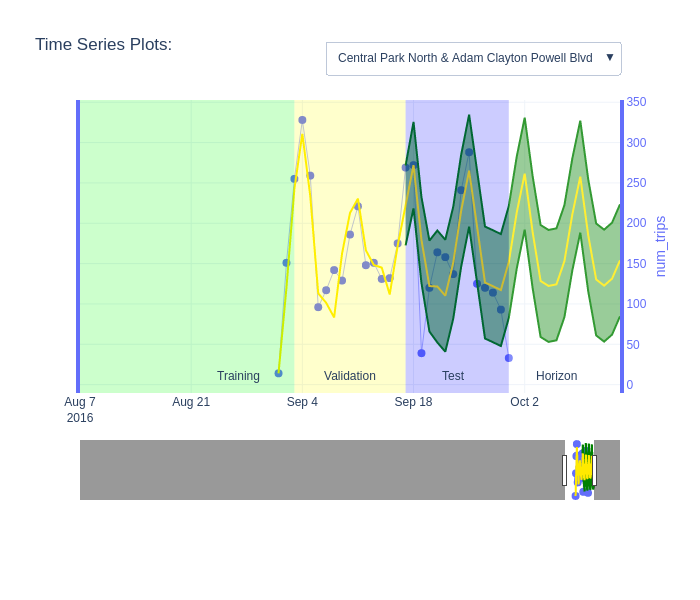

In [24]:
print('A Snapshot of the interactive plot:')
fig.show('png')

使用SQL计算指标

用于评估预测有效性的一些常见指标包括
- MAPE，即平均绝对百分比误差
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE，即平均绝对误差
    - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE除以平均需求，得到类似MAPE的百分比
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE，即均方误差
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE，即均方根误差
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE除以平均需求，得到类似MAPE的百分比
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

将这些指标明确计算出来有助于在数据集和模型之间进行公平比较。本节演示如何使用SQL计算这些指标。

```sql
(actual_value - forecast_value) as diff


AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
AVG(ABS(diff)) as MAE,
SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
AVG(POW(diff, 2)) as MSE,
SQRT(AVG(POW(diff, 2))) as RMSE,
SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
```

In [25]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                {SERIES_COLUMN}, 
                EXTRACT(DATE from time_series_timestamp) as {TIME_COLUMN},
                time_series_adjusted_data as forecast_value,
                time_series_type
            FROM ML.EXPLAIN_FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`,
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level))
            WHERE time_series_type = 'forecast'
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT {SERIES_COLUMN}, time_series_type, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}, time_series_type
    ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)

start_station_name time_series_type      MAPE  \
0   Central Park North & Adam Clayton Powell Blvd         forecast  0.654976   
1                          Central Park S & 6 Ave         forecast  0.442171   
2                        Central Park W & W 96 St         forecast  0.541691   
3                    Central Park West & W 100 St         forecast  0.875371   
4                    Central Park West & W 102 St         forecast  0.531504   
5                     Central Park West & W 68 St         forecast  0.432078   
6                     Central Park West & W 72 St         forecast  0.574050   
7                     Central Park West & W 76 St         forecast  0.373255   
8                     Central Park West & W 85 St         forecast  0.952959   
9               Grand Army Plaza & Central Park S         forecast  0.442275   
10                   W 106 St & Central Park West         forecast  0.275309   
11                    W 82 St & Central Park West         forecast  0.342769   

          MAE      pMAE           MSE        RMSE     pRMSE  
0   40.519533  0.261055   3339.344260   57.787060  0.372305  
1   86.673929  0.265580  12227.126512  110.576338  0.338820  
2   21.729312  0.217138   1016.374801   31.880634  0.318579  
3   18.610058  0.469443    482.209233   21.959263  0.553927  
4   14.568555  0.287672    332.562812   18.236305  0.360096  
5   42.457613  0.280248   2430.773248   49.302873  0.325432  
6   37.385787  0.211311   3406.825214   58.368015  0.329906  
7   27.026844  0.246820   1181.265559   34.369544  0.313877  
8   53.979223  0.429380   4709.508389   68.625858  0.545888  
9   51.585408  0.237216   5100.789447   71.419811  0.328425  
10  14.356956  0.214970    323.219810   17.978315  0.269194  
11  32.113632  0.347981   1781.537621   42.208265  0.457365

整体指标:

In [26]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                {SERIES_COLUMN}, 
                EXTRACT(DATE from time_series_timestamp) as {TIME_COLUMN},
                time_series_adjusted_data as forecast_value,
                time_series_type
            FROM ML.EXPLAIN_FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`, 
                STRUCT({FORECAST_TEST_LENGTH} AS horizon, 0.95 AS confidence_level))
            WHERE time_series_type = 'forecast'
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE {SPLIT_COLUMN} = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
        AVG(ABS(diff)) as MAE,
        SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

time_series_type      MAPE        MAE     pMAE          MSE       RMSE  \
0         forecast  0.518558  35.894781  0.26801  2938.159392  54.204791   

      pRMSE  
0  0.404722

异常检测
参考[`ML.DETECT_ANOMALIES`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies)

In [27]:
query = f"""
    SELECT * EXCEPT({TIME_COLUMN}), CAST(DATE({TIME_COLUMN}) AS date) AS {TIME_COLUMN}
    FROM ML.DETECT_ANOMALIES(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus`,
        STRUCT(0.95 as anomaly_prob_threshold),
        (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        )
        )
    WHERE anomaly_probability >= 0.95
"""
anomalies = bq.query(query).to_dataframe()
anomalies.head(viz_limit)

start_station_name  num_trips  is_anomaly  \
0                     Central Park West & W 85 St      258.0        True   
1                    Central Park West & W 102 St       10.0        True   
2                        Central Park W & W 96 St       18.0        True   
3                     Central Park West & W 72 St       33.0        True   
4   Central Park North & Adam Clayton Powell Blvd       33.0        True   
5                     W 82 St & Central Park West       34.0        True   
6                     Central Park West & W 76 St       39.0        True   
7   Central Park North & Adam Clayton Powell Blvd       39.0        True   
8               Grand Army Plaza & Central Park S       43.0        True   
9                     Central Park West & W 68 St       45.0        True   
10                         Central Park S & 6 Ave       60.0        True   
11                    Central Park West & W 68 St       70.0        True   

    lower_bound  upper_bound  anomaly_probability   starttime  
0     59.542503   191.342093             0.999786  2016-09-17  
1     14.513120    89.791480             0.971694  2016-09-30  
2     27.933173   166.329331             0.974811  2016-09-19  
3    141.294151   281.622456             0.999988  2016-09-30  
4     82.696895   221.440264             0.998872  2016-09-30  
5     38.050623    92.495964             0.975460  2016-09-19  
6     94.575727   170.047458             0.999982  2016-09-30  
7    125.923309   232.359466             0.999992  2016-09-19  
8    102.559709   233.238905             0.999625  2016-09-30  
9    103.375794   218.021116             0.999794  2016-09-30  
10   122.958187   277.433702             0.999354  2016-09-30  
11    77.143266   162.503692             0.977635  2016-09-19

### 使用预测和异常值可视化时间序列

In [28]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] # + COVARIATE_COLUMNS # no covariate for univarate forecasting

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast prediction funnel to test and horizon: lower
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s]['time_series_timestamp'],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    name = f'Lower Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_lower_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast prediction funnel to test and horizon: upper
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s]['time_series_timestamp'],
                    y = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    name = f'Upper Prediction: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['prediction_interval_upper_bound'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(0,128,0)'},
                    mode = 'lines',
                    fillcolor = 'rgba(0,128,0,0.5)',
                    fill = 'tonexty',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = explain[explain[SERIES_COLUMN]==s]['time_series_timestamp'],
                    y = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    name = f'Forecast: {v}',
                    text = explain[explain[SERIES_COLUMN]==s]['time_series_adjusted_data'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
            # add anomalies detected by forecast fit
            fig.add_trace(
                go.Scatter(
                    x = anomalies[anomalies[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = anomalies[anomalies[SERIES_COLUMN]==s][TARGET_COLUMN],
                    name = f'Anamaly: {v}',
                    text = anomalies[anomalies[SERIES_COLUMN]==s][TARGET_COLUMN],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    marker = {'size': 8, 'color': 'rgb(255,0,0)'},
                    mode = 'markers',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 4 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = FORECAST_HORIZON_LENGTH)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

A Snapshot of the interactive plot:


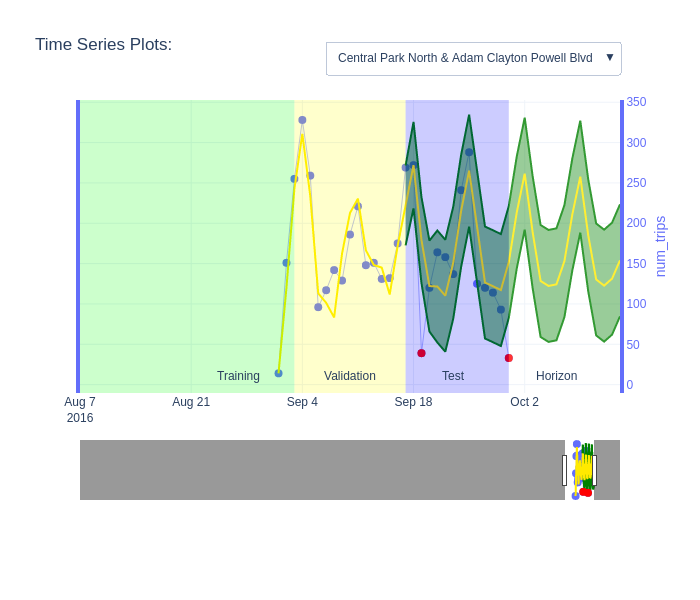

In [29]:
print('A Snapshot of the interactive plot:')
fig.show('png')

删除资源

要删除在BigQuery中创建的模型，请取消注释`bq.delete_model`语句，并运行下面的单元格：

In [30]:
# delete BigQuery Model
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus')
#bq.delete_model(model)